In [1]:
from IPython.display import display, HTML
import os
import pandas as pd
import numpy as np
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

from libs.sql_lib.sql import SQLClient
from settings import docs_path

In [2]:
sns.set(style="whitegrid")

# Análise Exploratória

### Obtenção da base de dados

In [3]:
data = pd.read_csv(os.path.join(docs_path, 'data.csv'))

### Visualização da base de dados

In [4]:
display(data)

,matchId,participants,endOfGameResult,timePlayed,gameVersion,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,firstTower,...,100_JUNGLE,100_MIDDLE,100_TOP,100_UTILITY,200_BOTTOM,200_JUNGLE,200_MIDDLE,200_TOP,200_UTILITY,gameStartDate
0,BR1_3010891752,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,2249.354,14.20.623.6777,0,0,1.728968e+09,True,False,...,Vi,Malzahar,Darius,Seraphine,Smolder,Skarner,Taliyah,Yone,Pyke,2024-10-15
1,BR1_3010900586,"[""t1MptRkCqbuZLIerEjiY2-HUa3jBtMlCWBNdpMlUxSkV...",GameComplete,1830.368,14.20.623.6777,0,0,1.728971e+09,True,False,...,Nocturne,Ahri,Volibear,Seraphine,Ashe,FiddleSticks,Anivia,Tryndamere,Sylas,2024-10-15
2,BR1_3010910689,"[""RtPADu3TOFINdvaaLKYtoO4Kcmt4Rd4MIERMkCaUTYbe...",GameComplete,1829.868,14.20.623.6777,0,0,1.728978e+09,True,False,...,Nunu,Kalista,Camille,Thresh,Ashe,JarvanIV,Kassadin,Urgot,Seraphine,2024-10-15
3,BR1_3010910840,"[""gP_dHfHa4JNW05lseUFfvj-WzOtxuroeRAAnynflaAbR...",GameComplete,1449.219,14.20.623.6777,0,0,1.728979e+09,True,False,...,Talon,Vex,Irelia,Pyke,Smolder,Khazix,Yone,Jax,Zoe,2024-10-15
4,BR1_3010911395,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,1596.042,14.20.623.6777,0,0,1.728976e+09,True,False,...,Qiyana,Ryze,KSante,Janna,Jinx,Karthus,Annie,TahmKench,Lulu,2024-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19729,BR1_3045138141,"[""BetEIxrtAIlInNcpH5zk2oKYrpG5eyP34cJg6q7LiVYf...",GameComplete,935.708,14.24.644.2327,1,0,1.735328e+09,True,False,...,Graves,Irelia,Aurora,Poppy,Karthus,FiddleSticks,Riven,Yone,Ashe,2024-12-27
19730,BR1_3045142382,"[""PytDMbfTsWLh2XHFtSiy752dRlHTBbBOBbRBP8X_meOK...",GameComplete,1164.522,14.24.644.2327,1,0,1.735329e+09,False,False,...,Rengar,Karthus,Gnar,Lulu,Varus,Zed,Malzahar,Jax,Nautilus,2024-12-27
19731,BR1_3045147939,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,1136.510,14.24.644.2327,1,0,1.735330e+09,True,False,...,FiddleSticks,Yasuo,Yone,Pyke,Jinx,Khazix,Irelia,Rumble,TahmKench,2024-12-27
19732,BR1_3045159983,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,100.717,14.24.644.2327,0,1,1.735332e+09,False,False,...,Ekko,Zed,Yasuo,TahmKench,Ezreal,Skarner,Irelia,Gragas,Leona,2024-12-27


### Verificação dos tipos das variáveis

In [5]:
dtypes_data = pd.DataFrame(data.dtypes)
print(dtypes_data)

                       0
matchId           object
participants      object
endOfGameResult   object
timePlayed       float64
gameVersion       object
...                  ...
200_JUNGLE        object
200_MIDDLE        object
200_TOP           object
200_UTILITY       object
gameStartDate     object

[104 rows x 1 columns]


In [6]:
data['win'] = data['win'].astype(int)

### Análise de Unicidade e Missings

In [6]:
print(f"Nº de registros duplicados:\n{data.duplicated(subset = 'matchId').sum()}\n")

print(f"Quantidade de valores nulos por colunas:\n{data.isnull().sum()}")

Nº de registros duplicados:
0

Quantidade de valores nulos por colunas:
matchId            0
participants       0
endOfGameResult    0
timePlayed         0
gameVersion        0
                  ..
200_JUNGLE         0
200_MIDDLE         0
200_TOP            0
200_UTILITY        0
gameStartDate      0
Length: 104, dtype: int64


### Análise Univariada

In [ ]:
data.describe()

#### Distribuição das Variáveis

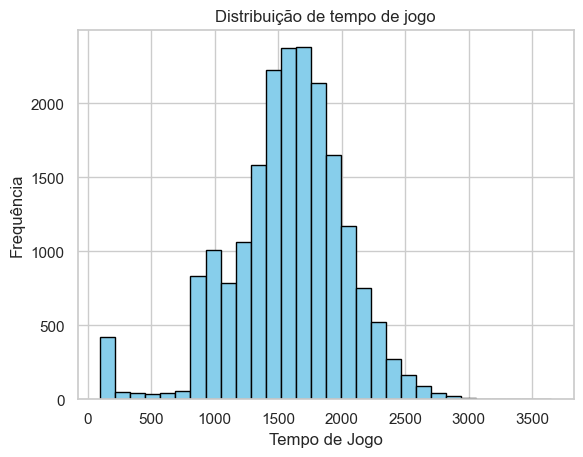

In [7]:
data['timePlayed'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição de tempo de jogo')
plt.xlabel('Tempo de Jogo')
plt.ylabel('Frequência')
plt.show()

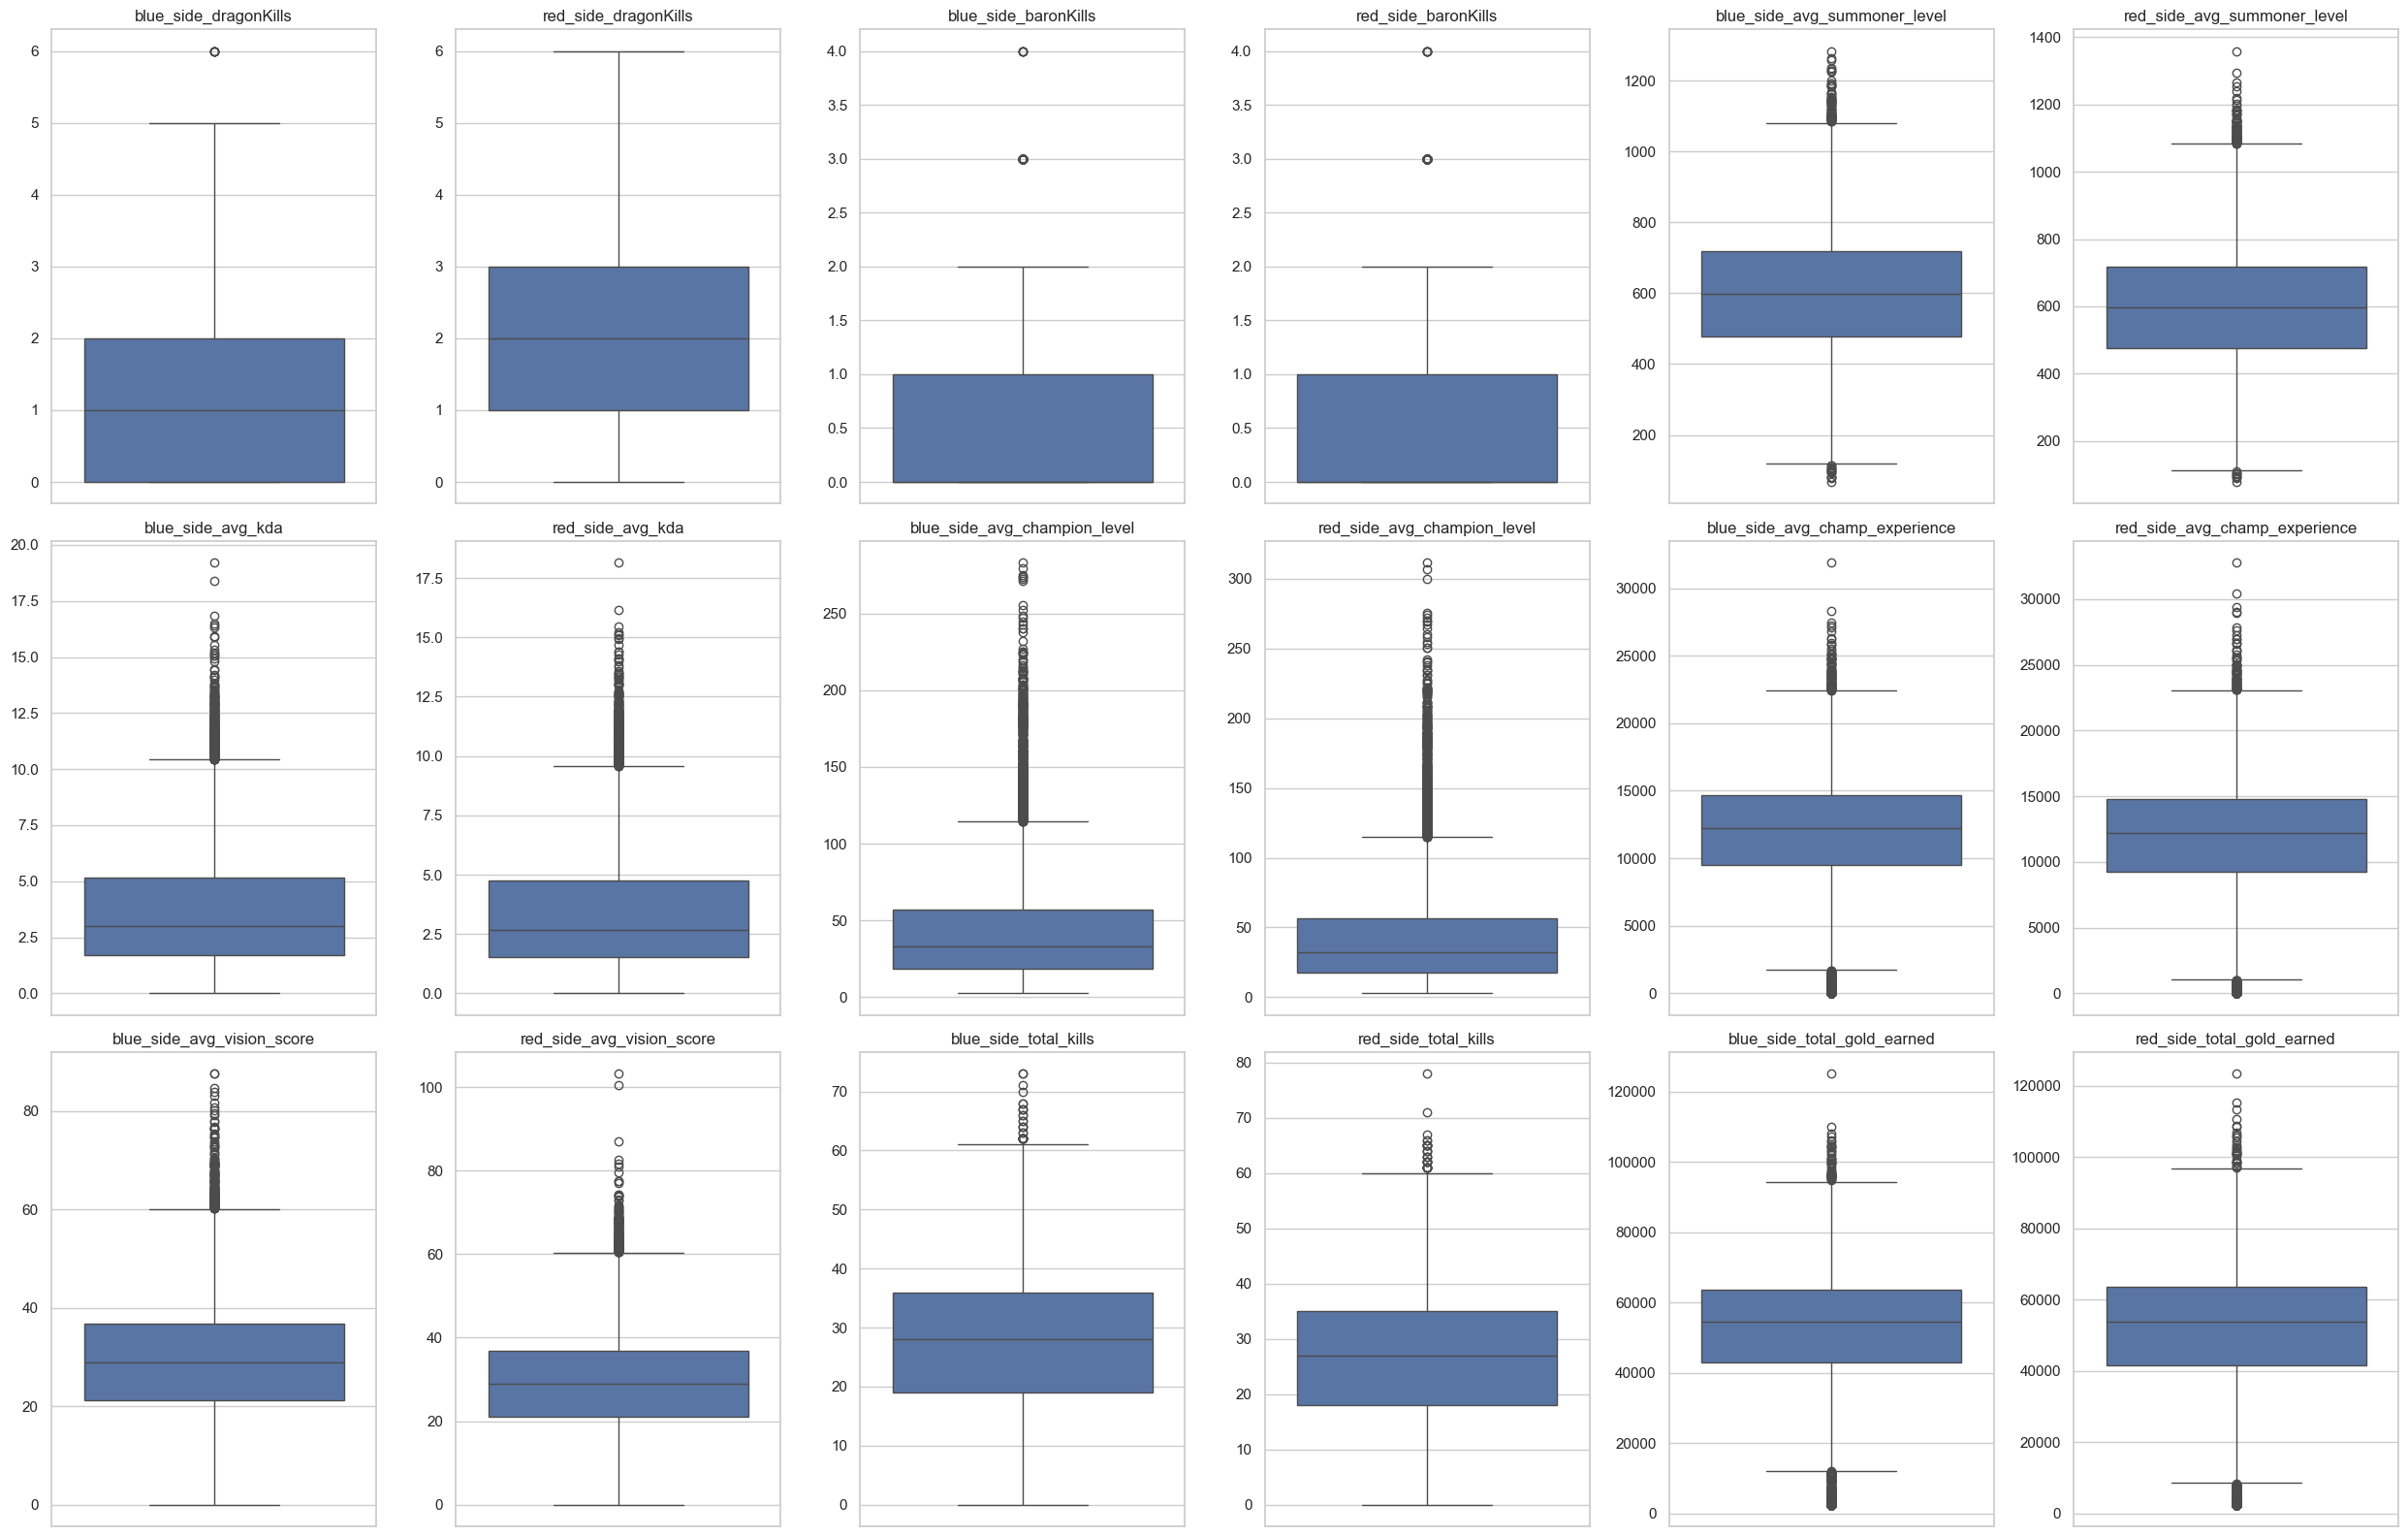

In [8]:
data_num = data[['blue_side_dragonKills', 'red_side_dragonKills', 'blue_side_baronKills', 'red_side_baronKills', 'blue_side_avg_summoner_level', 'red_side_avg_summoner_level', 'blue_side_avg_kda', 'red_side_avg_kda', 'blue_side_avg_champion_level', 'red_side_avg_champion_level', 'blue_side_avg_champ_experience', 'red_side_avg_champ_experience', 'blue_side_avg_vision_score', 'red_side_avg_vision_score', 'blue_side_total_kills', 'red_side_total_kills', 'blue_side_total_gold_earned', 'red_side_total_gold_earned']]

num_cols = 6
num_rows = (len(data_num.columns) // num_cols) + (1 if len(data_num.columns) % num_cols > 0 else 0)

plt.figure(figsize=(25, 16))
for i, col in enumerate(data_num.columns):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=data_num[col])
    ax.set_title(col)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

#### Proporção de Vitórias

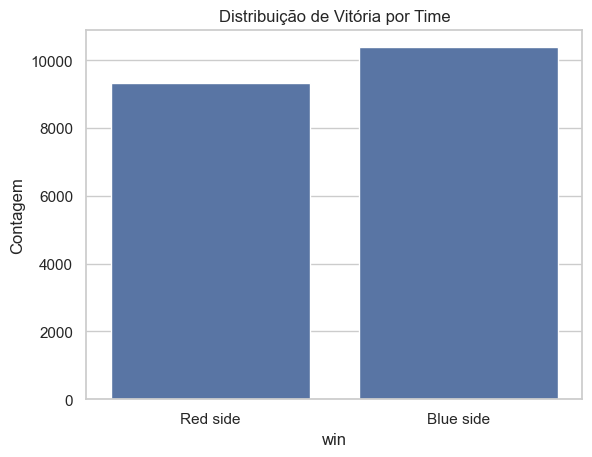

In [32]:
sns.countplot(x='win', data=data)
plt.title('Distribuição de Vitória por Time')
plt.xticks([0, 1], ['Red side', 'Blue side'])
plt.ylabel('Contagem')
plt.show()

#### Top 5 campeões mais jogados por posição e lado

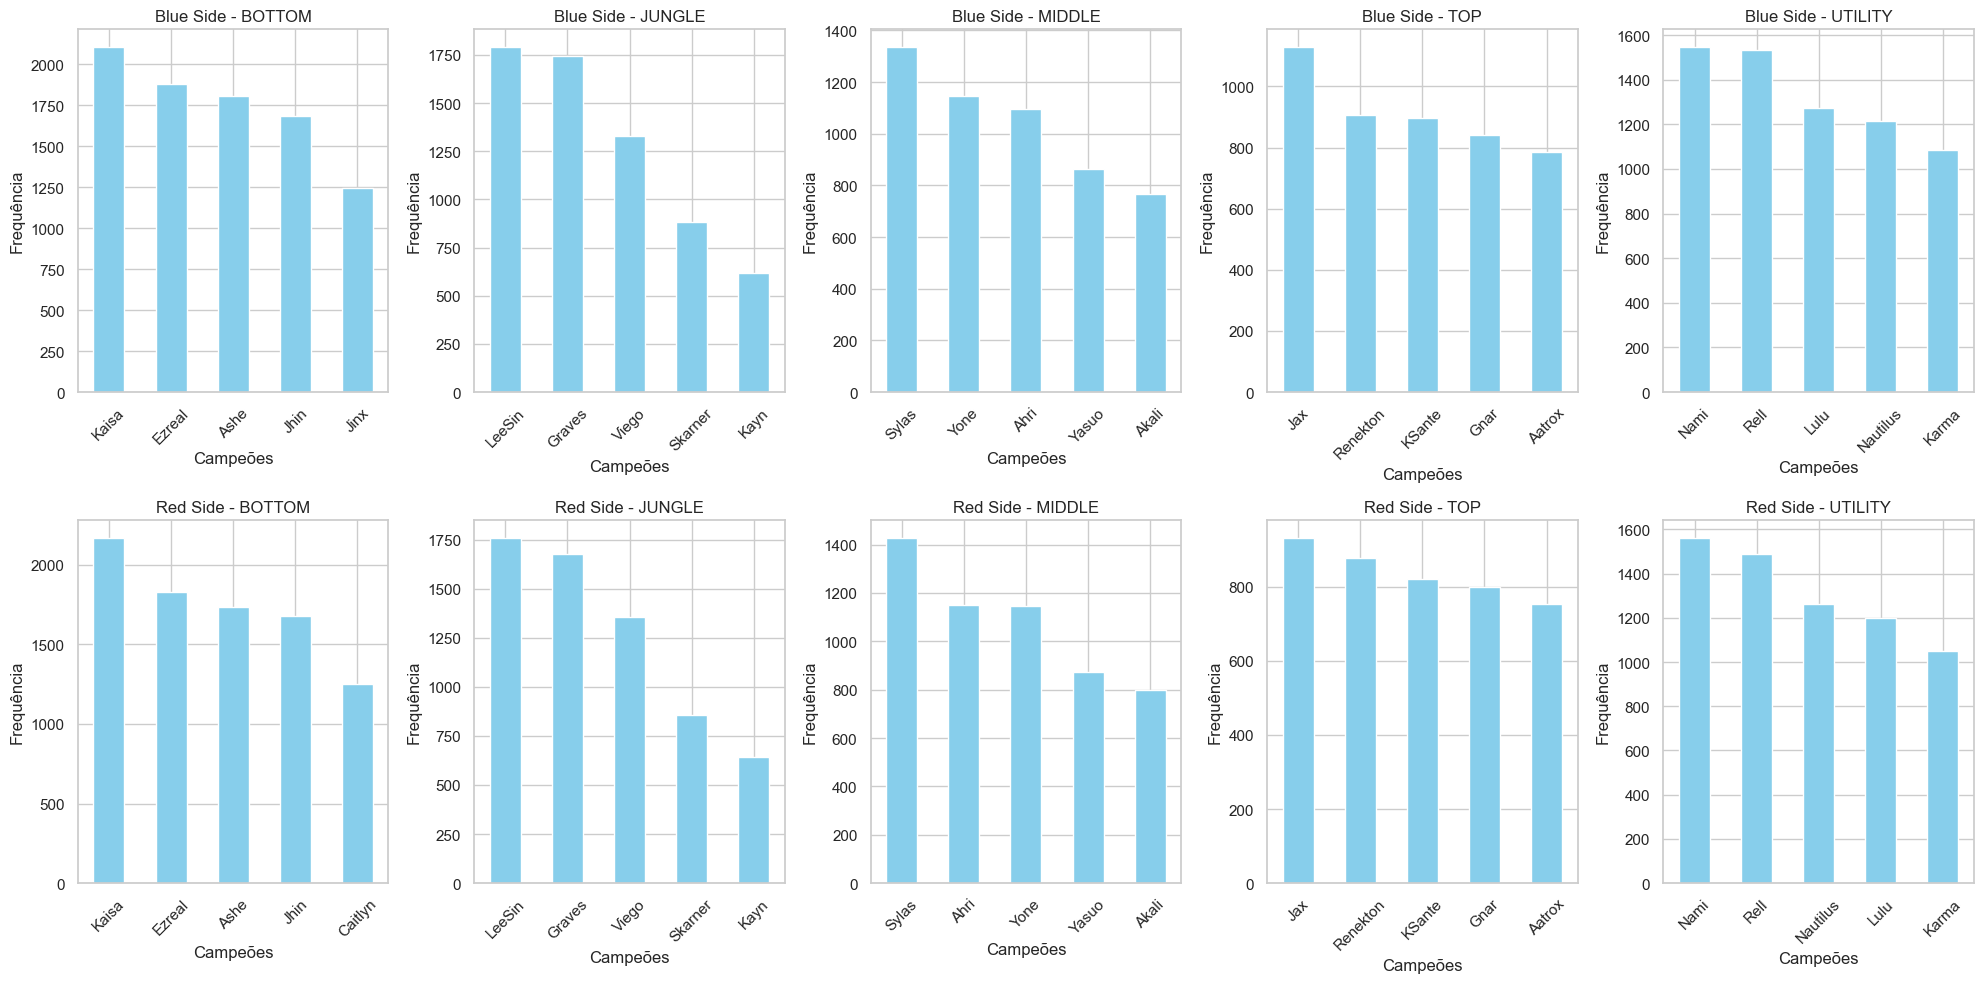

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten() 

lane_columns = [col for col in data.columns if col.startswith('100_') or col.startswith('200_')]

for i, col in enumerate(lane_columns):
    freq = data[col].value_counts()
    top_freq = freq.head(5)

    side = "Blue Side" if col.startswith("100_") else "Red Side"
    lane = col.split('_')[1] 
    title = f'{side} - {lane}'
    
    ax = axes[i]
    top_freq.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Campeões')
    ax.set_ylabel('Frequência')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Análise Bivariada

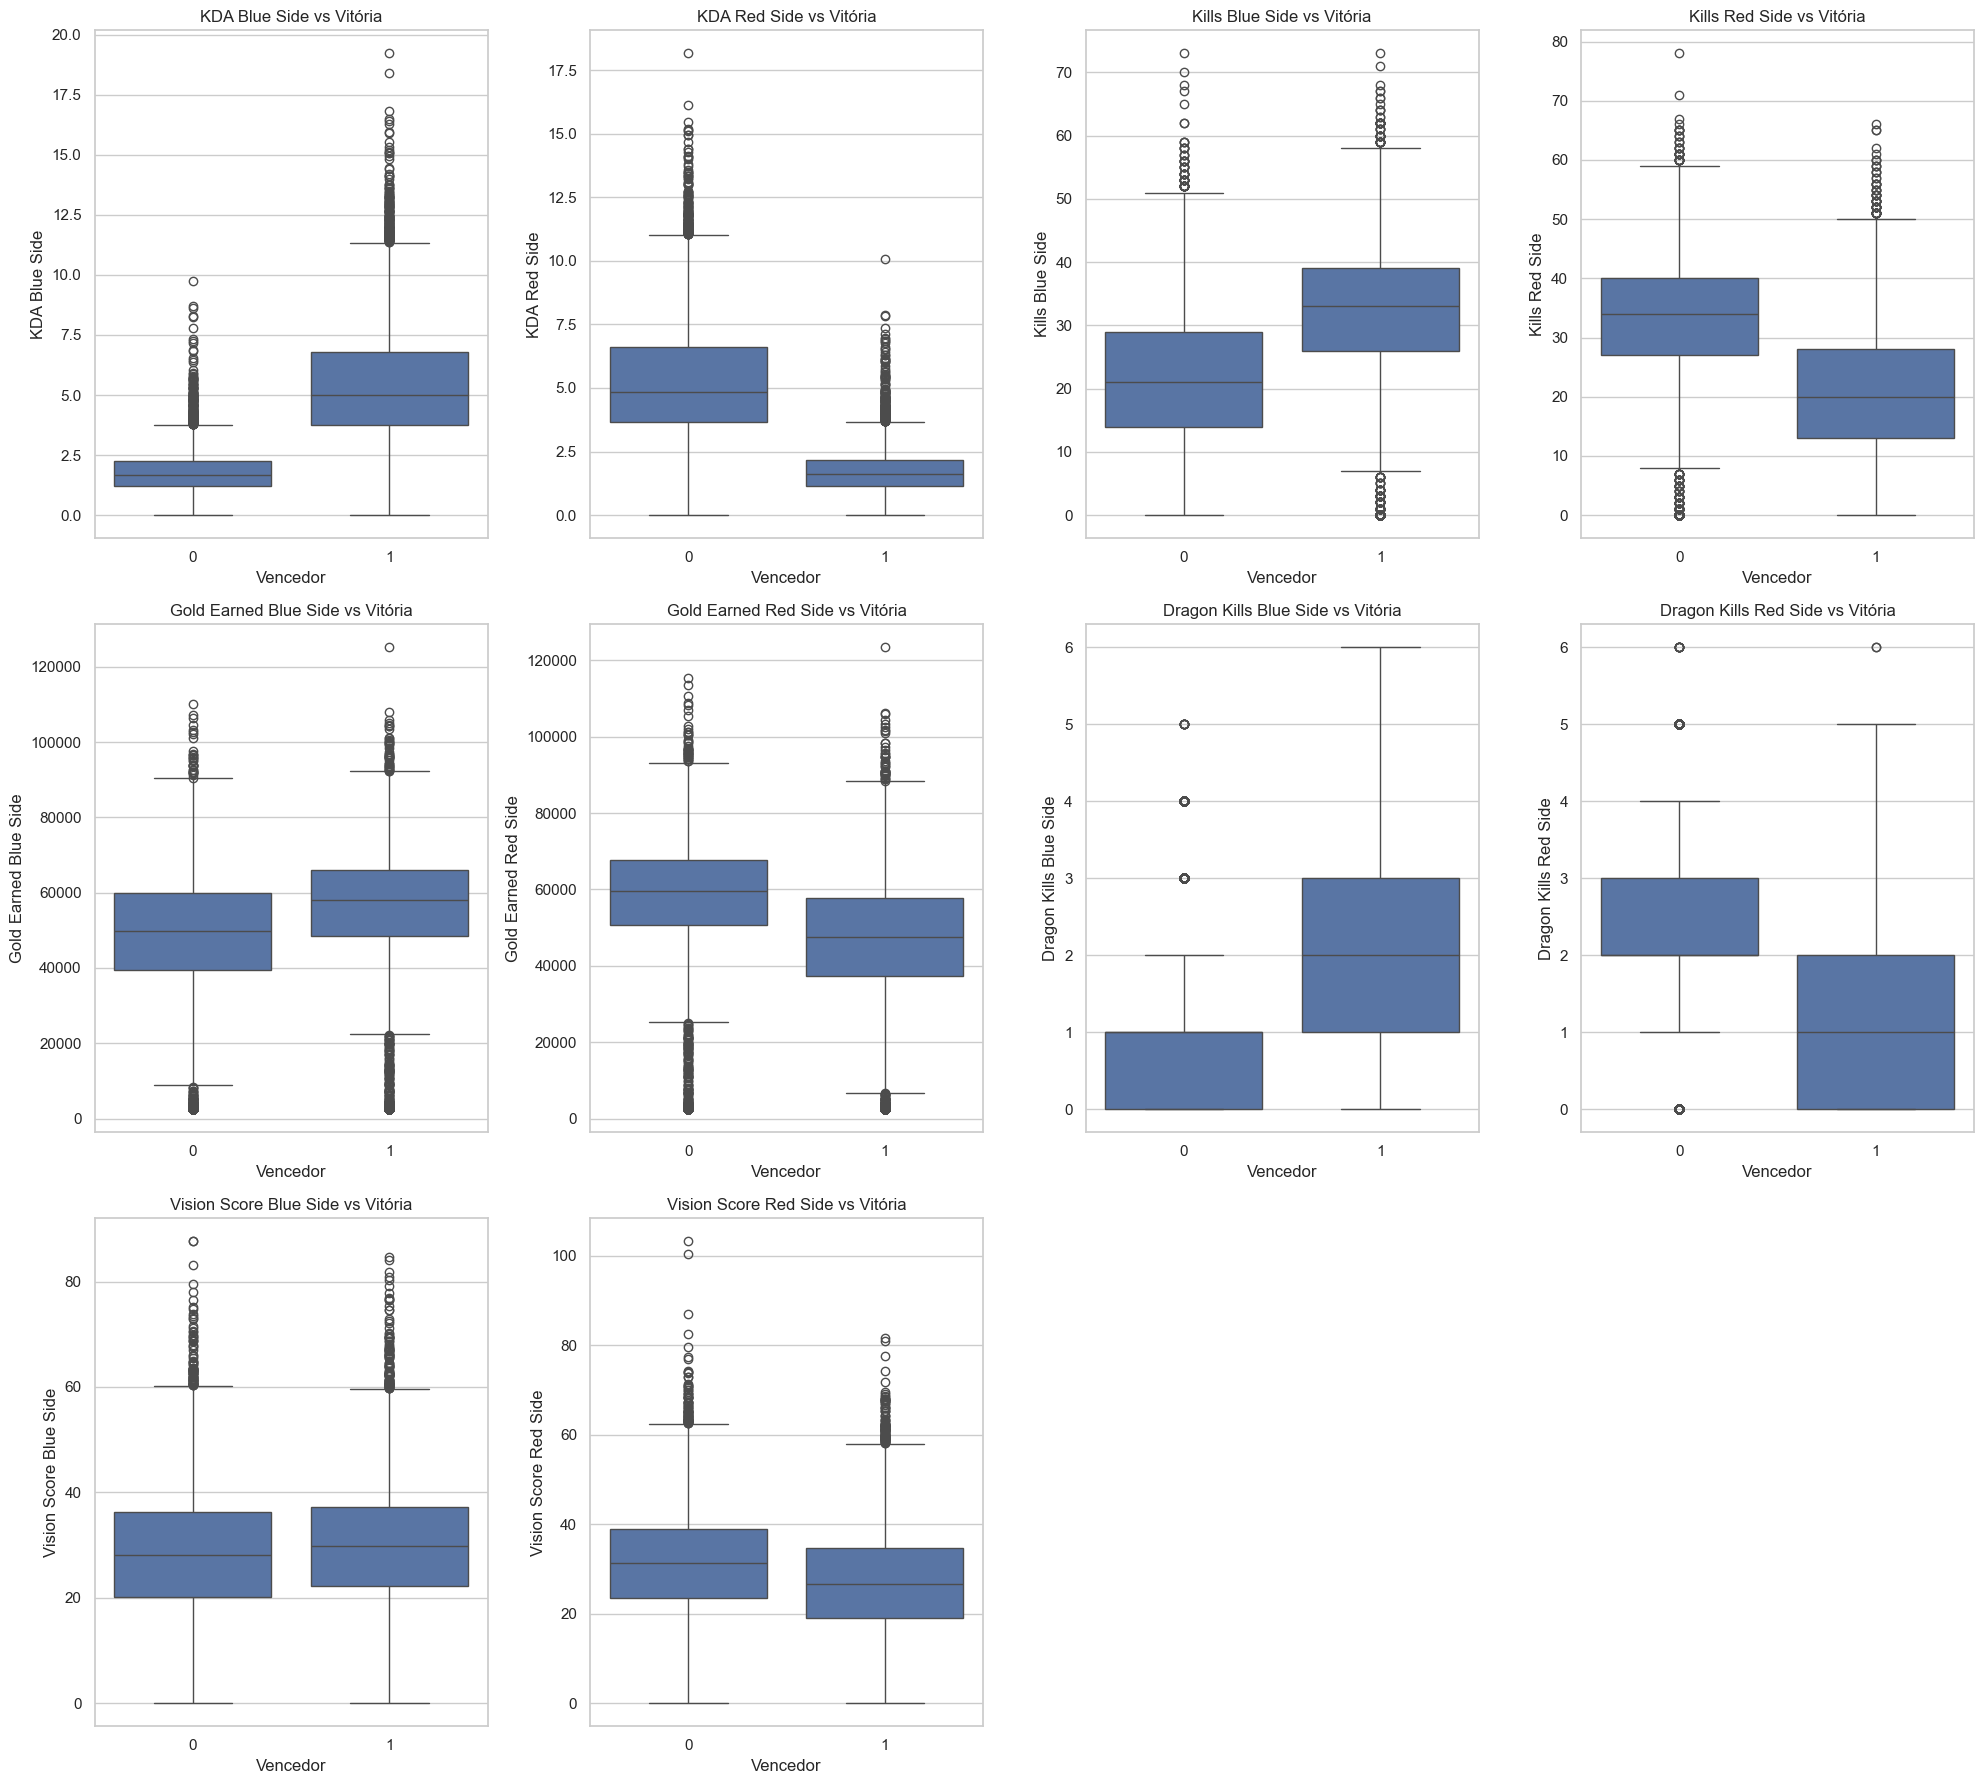

In [31]:
numerical_variables = [
    'blue_side_avg_kda', 'red_side_avg_kda', 
    'blue_side_total_kills', 'red_side_total_kills', 
    'blue_side_total_gold_earned', 'red_side_total_gold_earned',
    'blue_side_dragonKills', 'red_side_dragonKills',
    'blue_side_avg_vision_score', 'red_side_avg_vision_score'
]

y_label = ['KDA Blue Side', 'KDA Red Side', 
           'Kills Blue Side', 'Kills Red Side', 
           'Gold Earned Blue Side', 'Gold Earned Red Side',
           'Dragon Kills Blue Side', 'Dragon Kills Red Side',
           'Vision Score Blue Side', 'Vision Score Red Side']

plt.figure(figsize=(20, 18))

for i, col in enumerate(numerical_variables):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data=data, x='win', y=col)
    plt.xlabel('Vencedor')
    plt.ylabel(y_label[i])
    plt.title(f'{y_label[i]} vs Vitória')

plt.tight_layout()
plt.show()


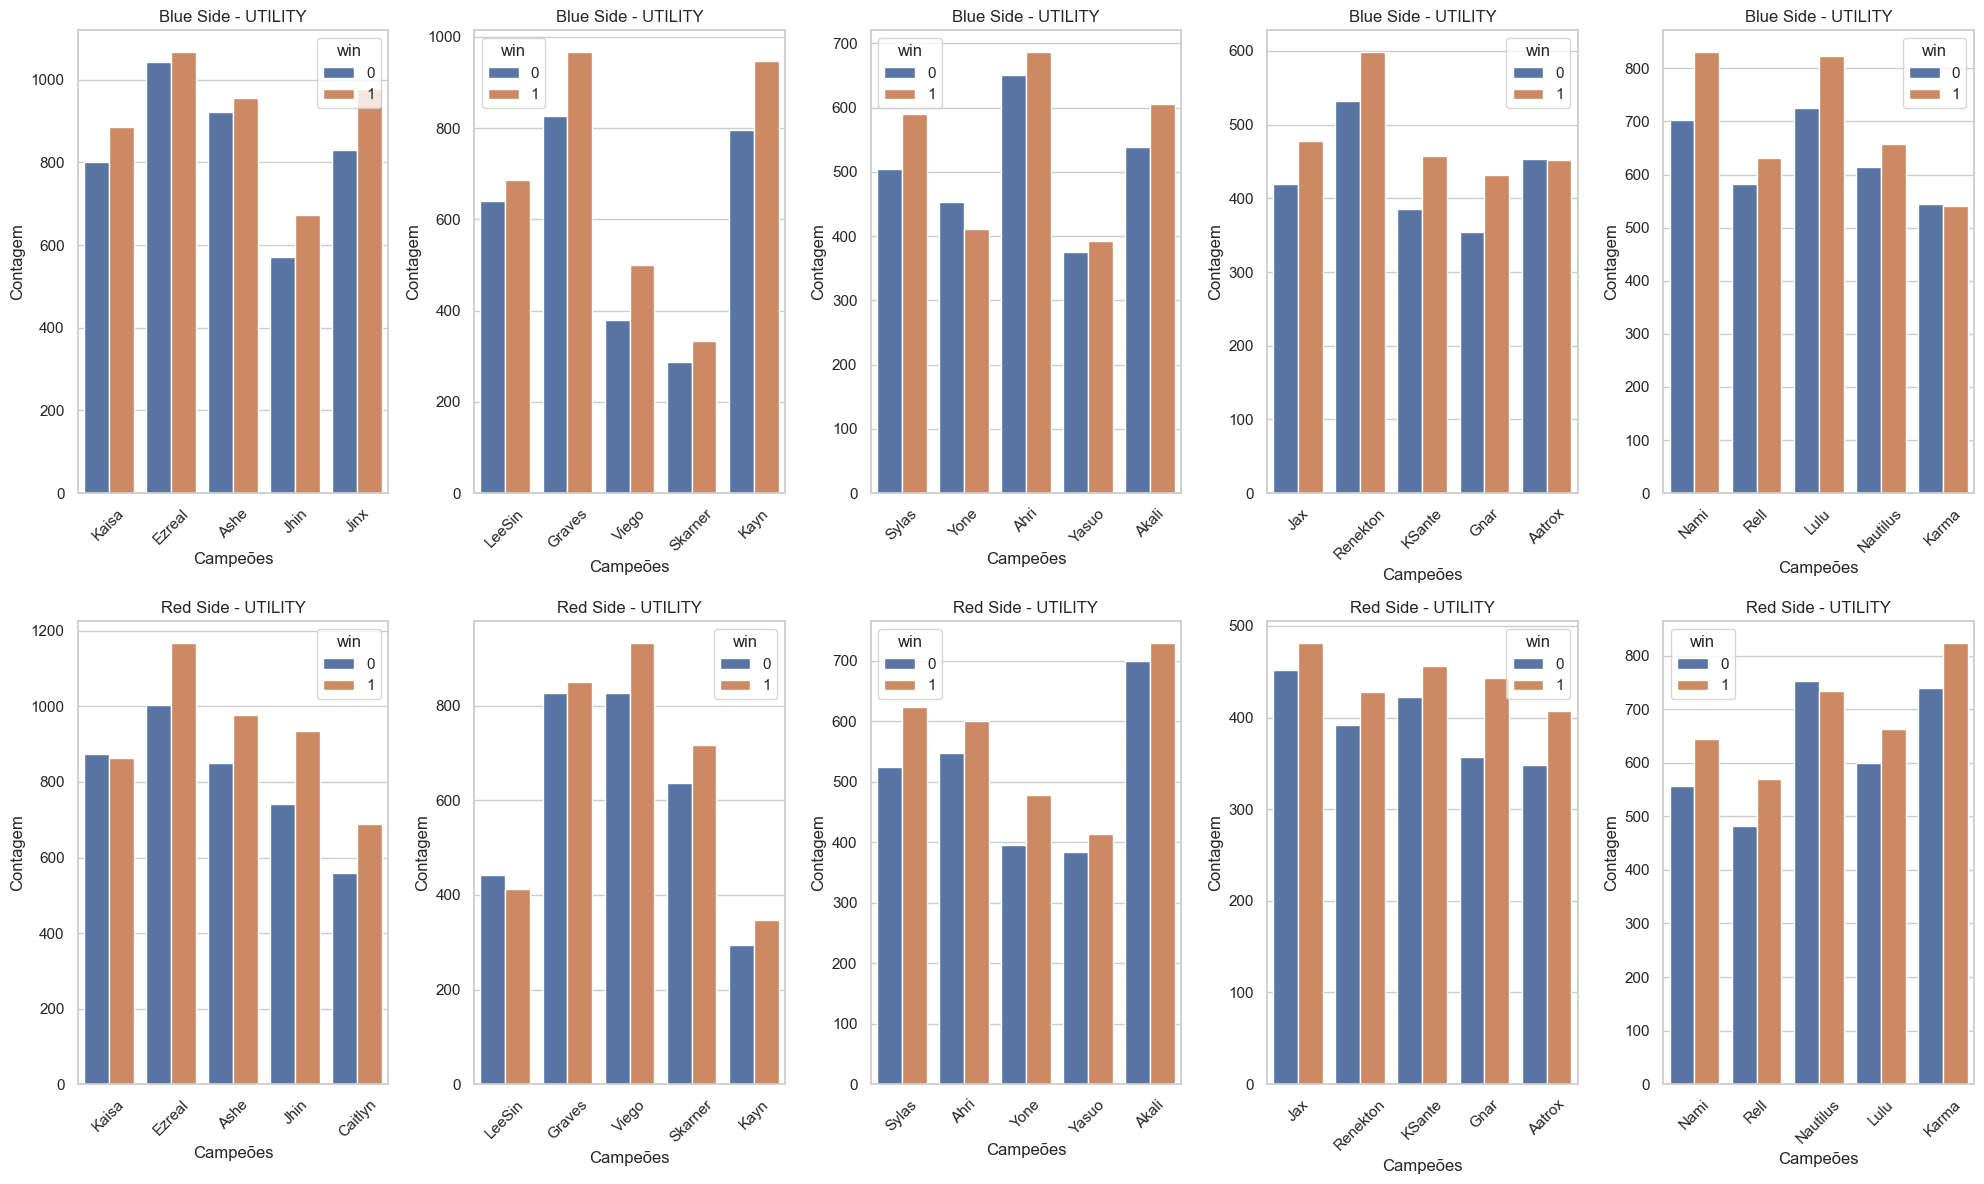

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

for i, lane in enumerate(lane_columns):
    top_champions = data[lane].value_counts().nlargest(5).index
    sns.countplot(x=lane, data=data[data[lane].isin(top_champions)], hue='win', ax=axes[i])
    
    side = "Blue Side" if lane.startswith("100_") else "Red Side"
    lane = col.split('_')[1]
    title = f'{side} - {lane}'
    
    axes[i].set_title(title)
    
    axes[i].set_xticks(range(5))
    axes[i].set_xticklabels(top_champions, rotation=45)
    axes[i].set_ylabel('Contagem')
    axes[i].set_xlabel('Campeões')
    
plt.tight_layout()
plt.show()
